## Desafio - Cálculo de Métricas de Avaliação de Aprendizado

In [1]:
pip install tensorflow-addons==0.23.0

In [2]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
tf.__version__

'2.17.1'

In [4]:
%load_ext tensorboard

In [5]:
logdir='log'

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes = [0,1,2,3,4,5,6,7,8,9]

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [9]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x=train_images, y=train_labels, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8812 - loss: 0.3670 - val_accuracy: 0.9833 - val_loss: 0.0475
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9837 - loss: 0.0540 - val_accuracy: 0.9879 - val_loss: 0.0396
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9893 - loss: 0.0358 - val_accuracy: 0.9896 - val_loss: 0.0347
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9906 - loss: 0.0293 - val_accuracy: 0.9885 - val_loss: 0.0351
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9930 - loss: 0.0224 - val_accuracy: 0.9889 - val_loss: 0.0401


In [10]:
y_true=test_labels
y_pred = np.argmax(model.predict(test_images), axis=-1)



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [11]:
classes = [0,1,2,3,4,5,6,7,8,9]

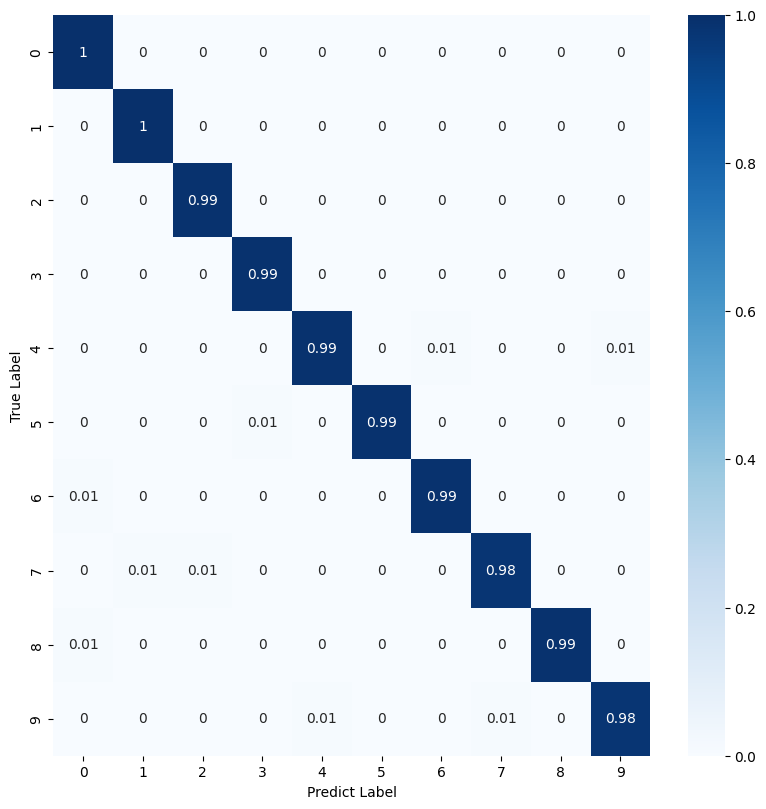

In [12]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)

figure = plt.figure(figsize=(8,8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predict Label')
plt.show()

#### Encontrando valores de VP, FP, FN, VN

In [13]:
metrics = {}
N = np.sum(con_mat)  # Número total de amostras

for c in classes:
    VP = con_mat[c, c]
    FP = np.sum(con_mat[:, c]) - VP
    FN = np.sum(con_mat[c, :]) - VP
    VN = N - (VP + FP + FN)

    metrics[c] = {"VP": VP, "FP": FP, "FN": FN, "VN": VN}

print(metrics[c])

{'VP': 984, 'FP': 8, 'FN': 25, 'VN': 8983}


#### Calculando métricas

In [14]:
for c in classes:
    VP = metrics[c]["VP"]
    FP = metrics[c]["FP"]
    FN = metrics[c]["FN"]
    VN = metrics[c]["VN"]

    # Evitar divisões por zero
    sensibilidade = VP / (VP + FN) if (VP + FN) > 0 else 0
    especificidade = VN / (FP + VN) if (FP + VN) > 0 else 0
    acuracia = (VP + VN) / N
    precisao = VP / (VP + FP) if (VP + FP) > 0 else 0
    f_score = (2 * (precisao * sensibilidade)) / (precisao + sensibilidade) if (precisao + sensibilidade) > 0 else 0

    metrics[c]["Sensibilidade"] = sensibilidade
    metrics[c]["Especificidade"] = especificidade
    metrics[c]["Acurácia"] = acuracia
    metrics[c]["Precisão"] = precisao
    metrics[c]["F-Score"] = f_score

#### Exibindo o resultado

In [15]:
from tabulate import tabulate

data = []

for c in classes:
    data.append([
        c,
        int(metrics[c]['VP']),
        int(metrics[c]['FP']),
        int(metrics[c]['FN']),
        int(metrics[c]['VN']),
        metrics[c]['Sensibilidade'],
        metrics[c]['Especificidade'],
        metrics[c]['Acurácia'],
        metrics[c]['Precisão'],
        metrics[c]['F-Score']
    ])

headers = ["Classe", "VP", "FP", "FN", "VN", "Sensibilidade", "Especificidade", "Acurácia", "Precisão", "F-Score"]

print(tabulate(data, headers=headers, tablefmt="fancy_grid", floatfmt={5: ".4f", 6: ".4f", 7: ".4f", 8: ".4f", 9: ".4f"}))

╒══════════╤══════╤══════╤══════╤══════╤═════════════════╤══════════════════╤════════════╤════════════╤═══════════╕
│   Classe │   VP │   FP │   FN │   VN │   Sensibilidade │   Especificidade │   Acurácia │   Precisão │   F-Score │
╞══════════╪══════╪══════╪══════╪══════╪═════════════════╪══════════════════╪════════════╪════════════╪═══════════╡
│        0 │  978 │   20 │    2 │ 9000 │        0.997959 │         0.997783 │     0.9978 │   0.97996  │  0.988878 │
├──────────┼──────┼──────┼──────┼──────┼─────────────────┼──────────────────┼────────────┼────────────┼───────────┤
│        1 │ 1134 │   18 │    1 │ 8847 │        0.999119 │         0.99797  │     0.9981 │   0.984375 │  0.991692 │
├──────────┼──────┼──────┼──────┼──────┼─────────────────┼──────────────────┼────────────┼────────────┼───────────┤
│        2 │ 1020 │   17 │   12 │ 8951 │        0.988372 │         0.998104 │     0.9971 │   0.983607 │  0.985984 │
├──────────┼──────┼──────┼──────┼──────┼─────────────────┼──────────────